# Análise exploratória dos dados

Este notebook deve ser lido após os `business_and_data_understanding` e também após a execução do script `get_data` caso seja necessário obter os dados novamente.

Como não colocamos uma forma de retry nas requisições é possível que muitas pautas não tenham sido obtidas por uma instabilidade nos links e na rede da câmara.

Os dados obtidos foram da semana 29/06/2025 a 05/06/2025.

Vamos ler os arquivos CSV contendo os dados que obtivemos com os scritps.

In [99]:
# !pip install matplotlib
# !pip install seaborn
# !pip install wordcloud
# !pip install spacy
# !pip install transformers
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install umap-learn
# !pip install numpy==2.2.0
# !pip install datasets
# !pip install scikit-learn
!pip install umap-learn

In [109]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

import seaborn as sns
import spacy
from collections import Counter, defaultdict

from umap import UMAP
from datasets import Dataset

from sklearn.preprocessing import MinMaxScaler

import torch


from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [3]:
# !python -m spacy download pt_core_news_sm

In [4]:
nlp = spacy.load("pt_core_news_sm")

In [5]:
# Vamos retornar para a origem do repositório
%cd ..

c:\Users\renne\Documents\repos\legislativo-nlp


In [6]:
events_with_topics = pd.read_csv("data/datasets/events_with_topics.csv", encoding="utf-8-sig")
motions = pd.read_csv("data/datasets/motions.csv", encoding="utf-8-sig")

In [7]:
events_with_topics.head()

,id,uri,dataHoraInicio,dataHoraFim,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,urlRegistro,details,topics
0,75916,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-01T10:00,NaN,Cancelada,Audiência Pública,Adaptação das Estruturas Físicas das Escolas F...,Plenário a definir,"[{'id': 2009, 'uri': 'https://dadosabertos.cam...","{'nome': None, 'predio': None, 'sala': None, '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
1,76160,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-01T13:00,NaN,Convocada,Audiência Pública,Planejamento e Diretrizes das ações do Governo...,NaN,"[{'id': 537480, 'uri': 'https://dadosabertos.c...","{'nome': 'Anexo II, Plenário 13', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",Pauta - CPD - 01/07/2025 13:00\nCÂMARA DOS DEP...
2,76192,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-01T13:00,NaN,Convocada,Seminário,Inclusão de diretrizes para uma educação antir...,NaN,"[{'id': 539384, 'uri': 'https://dadosabertos.c...","{'nome': 'Anexo II, Plenário 12', 'predio': No...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",Pauta - CPOVOS - 01/07/2025 13:00\nCÂMARA DOS ...
3,76323,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-02T11:00,NaN,Agendada,Sessão Não Deliberativa Solene,"Homenagem aos 77 anos da Nakba, a catástrofe p...",NaN,"[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': 'Plenário da Câmara dos Deputados', '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN
4,76326,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-02T09:00,NaN,Agendada,Sessão Não Deliberativa Solene,Homenagem aos 20 anos do Instituto Sabin\r\n S...,NaN,"[{'id': 180, 'uri': 'https://dadosabertos.cama...","{'nome': 'Plenário da Câmara dos Deputados', '...",NaN,"{'uriDeputados': None, 'uriConvidados': None, ...",NaN


Vemos que os arquivos foram salvos corretamente, apenas temos a transformações dos None originais para NaN.

In [8]:
events_with_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              80 non-null     int64  
 1   uri             80 non-null     object 
 2   dataHoraInicio  80 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        80 non-null     object 
 5   descricaoTipo   80 non-null     object 
 6   descricao       80 non-null     object 
 7   localExterno    15 non-null     object 
 8   orgaos          80 non-null     object 
 9   localCamara     80 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         80 non-null     object 
 12  topics          35 non-null     object 
dtypes: float64(2), int64(1), object(10)
memory usage: 8.3+ KB


In [9]:
events_with_topics.describe(include="object")


,uri,dataHoraInicio,situacao,descricaoTipo,descricao,localExterno,orgaos,localCamara,details,topics
count,80,80,80,80,80,15,80,80,80,35
unique,80,36,3,13,67,13,37,22,80,35
top,https://dadosabertos.camara.leg.br/api/v2/even...,2025-07-02T10:00,Convocada,Audiência Pública,Discussão e votação de propostas legislativas,Plenário a definir,"[{'id': 2009, 'uri': 'https://dadosabertos.cam...","{'nome': None, 'predio': None, 'sala': None, '...","{'uriDeputados': None, 'uriConvidados': None, ...",Pauta - CPD - 01/07/2025 13:00\nCÂMARA DOS DEP...
freq,1,9,75,27,13,3,8,15,1,1


In [10]:
print(f"Eventos com pauta {events_with_topics.shape[0] - events_with_topics.topics.isnull().sum()}")

Eventos com pauta 35


Temos que apenas 35 pautas foram resgatadas, o que é menos que a metade dos eventos, como comentado previamente, podem ter ocorrido problemas na conexão com a página ou elas não estão disponíveis.

In [11]:
events_with_topics.descricaoTipo.value_counts()

descricaoTipo
Audiência Pública                           27
Reunião Deliberativa                        19
Seminário                                    9
Sessão Não Deliberativa Solene               6
Reunião Técnica                              6
Mesa Redonda                                 4
Reunião de Comparecimento de Ministro(a)     3
Audiência Pública e Deliberação              1
Homenagem                                    1
Outro Evento                                 1
Sessão Deliberativa                          1
Palestra                                     1
Visita Técnica                               1
Name: count, dtype: int64

Para a próxima semana o evento de maior predominância é de Audiência Pública, seguido de Reuniões deliberativas.

In [12]:
events_with_topics.situacao.value_counts()

situacao
Convocada    75
Agendada      4
Cancelada     1
Name: count, dtype: int64

Conseguimos visualizar também os 3 tipos de situação, onde a maioria (75) está convocada, 4 agendadas e apenas 1 cancelada.

Para visualizarmos os órgão que os eventos se referem precisamos tratar essa coluna e retirá-la do JSON original. Vamos considerar inicialmente que um evento pode possuir apenas uma comissão a que se refere.

In [13]:
events_with_topics.orgaos.iloc[0]

"[{'id': 2009, 'uri': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/2009', 'sigla': 'CE', 'nome': 'Comissão de Educação', 'apelido': 'Educação', 'codTipoOrgao': 2, 'tipoOrgao': 'Comissão Permanente', 'nomePublicacao': 'Comissão de Educação', 'nomeResumido': 'Educação'}]"

In [14]:
def extract_comission(orgao):
    try:
        orgaos = ast.literal_eval(orgao)  # Converte string para lista de dicts

        first_comission = orgaos[0].get("nome")
        return first_comission
    except Exception as e:
        print(f"Erro ao processar: {e}")
        return None

# Aplicar no DataFrame
events_with_topics["comission"] = events_with_topics["orgaos"].apply(extract_comission)

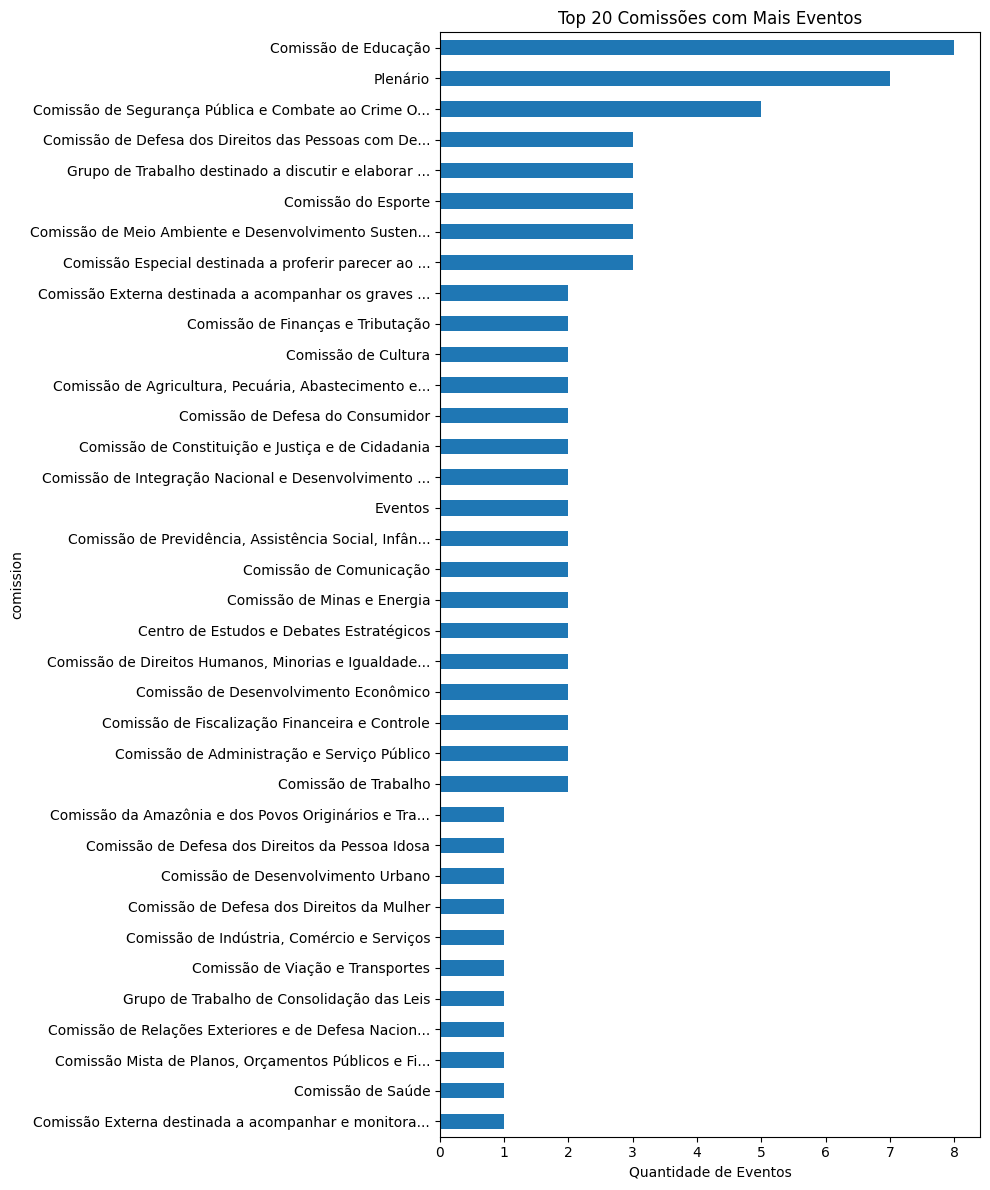

In [15]:
contagem_comissoes = events_with_topics["comission"].value_counts()

plt.figure(figsize=(10, 12))
ax = contagem_comissoes.plot(kind="barh")
plt.title("Top 20 Comissões com Mais Eventos")
plt.xlabel("Quantidade de Eventos")
plt.gca().invert_yaxis()
max_len = 50
yticklabels = [
    label.get_text()[:max_len] + "..." if len(label.get_text()) > max_len else label.get_text()
    for label in ax.get_yticklabels()
]
ax.set_yticklabels(yticklabels)

plt.tight_layout()
plt.show()

Temos a maioria dos eventos pela comissão de Educação seguido se sessões plenárias e posteriormente Comissão de segurança.

Vamos analisar os tamanhos das descrições e pautas.

Text(0.5, 1.0, 'Distribuição do Tamanho das descrições dos Eventos')

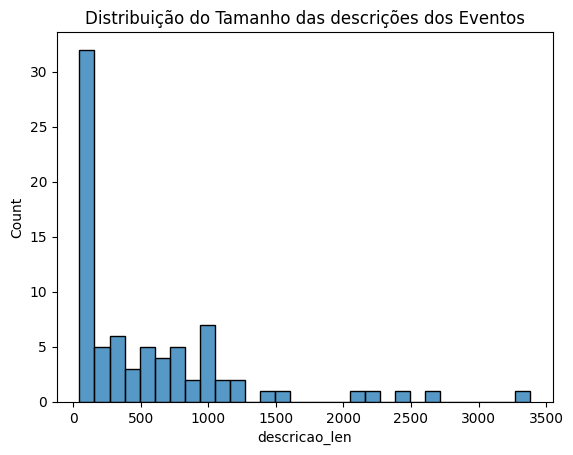

In [16]:
events_with_topics["descricao_len"] = events_with_topics["descricao"].str.len()
not_null_description_len = events_with_topics["descricao_len"].dropna()

sns.histplot(not_null_description_len, bins=30)
plt.title("Distribuição do Tamanho das descrições dos Eventos")

Text(0.5, 1.0, 'Distribuição do Tamanho das Pautas dos Eventos')

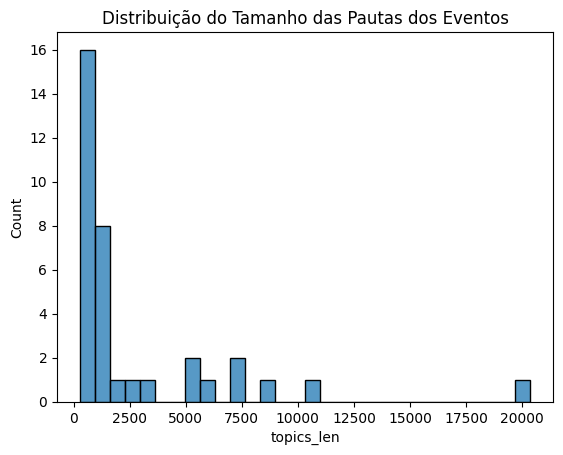

In [17]:
events_with_topics["topics_len"] = events_with_topics["topics"].str.len()
not_null_topics_len = events_with_topics["topics_len"].dropna()


sns.histplot(not_null_topics_len, bins=30)
plt.title("Distribuição do Tamanho das Pautas dos Eventos")


---

Vamos partir agora para a análise dos dados de requerimentos.

In [18]:
motions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   titulo    68 non-null     object
 1   uri       68 non-null     object
 2   event_id  68 non-null     int64 
 3   details   68 non-null     object
 4   status    68 non-null     object
 5   ementa    68 non-null     object
 6   pdf_url   68 non-null     object
 7   id        68 non-null     object
 8   pdf_text  68 non-null     object
dtypes: int64(1), object(8)
memory usage: 4.9+ KB


Temos 68 requerimentos para os 80 eventos, por hora foi decidido não agregá-los, então vamos analisá-los separadamente.

Todos os requerimentos apresentam campos não nulos, ou seja foi possível resgatar informações inclusive do PDF de todos.

In [19]:
motions.tail()

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
63,REQ 2033/2025,https://dadosabertos.camara.leg.br/api/v2/prop...,77039,"{'id': 2511893, 'uri': 'https://dadosabertos.c...",Aguardando Despacho do Presidente da Câmara do...,Requer a convocação de sessão solene da Câmara...,https://www.camara.leg.br/proposicoesWeb/prop_...,2033_2025,a\ns\ne\nM\n\n.\n\n-\n7\n4\n8\n4\n3\n:\n5\n2\n...
64,REQ 133/2025 CFFC,https://dadosabertos.camara.leg.br/api/v2/prop...,77051,"{'id': 2497118, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer o convite ao Secretário Extraordinário ...,https://www.camara.leg.br/proposicoesWeb/prop_...,133_2025,CÂMARA DOS DEPUTADOS\...
65,REQ 11/2025 CCOM,https://dadosabertos.camara.leg.br/api/v2/prop...,77057,"{'id': 2500416, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer o envio de convite ao Exmo. Senhor Fred...,https://www.camara.leg.br/proposicoesWeb/prop_...,11_2025,CÂMARA DOS DEPUTADOS\n\nGabinete do Deputado J...
66,REQ 18/2025 CCOM,https://dadosabertos.camara.leg.br/api/v2/prop...,77057,"{'id': 2509559, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Solicita que seja convocado o Excelentíssimo S...,https://www.camara.leg.br/proposicoesWeb/prop_...,18_2025,CÂMARA DOS DEPUTADOS\nGABINETE DO DEPUTADO GUS...
67,REQ 1/2025 CEXRSFEM,https://dadosabertos.camara.leg.br/api/v2/prop...,77066,"{'id': 2520689, 'uri': 'https://dadosabertos.c...",Aguardando Deliberação,"Requer a realização de 2 (dois) Seminários, a ...",https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,CÂMARA DOS DEPUTADOS\n\nCOMISSÃO EXTERNA SOBRE...


Vamos verificar se não há duplicatas

In [20]:
motions.duplicated(subset=["id"]).sum()

np.int64(18)

Temos requerimentos com duplicatas nos IDs! Isso levanta uma necessidade de análise, foi identificado que requerimentos podem ter IDs iguais porém textos diferentes! Isso torna uma necessidade de resgatarmos os dados novamente pois os pdfs foram salvos com base inicialmente no ID.

In [21]:
motions[motions["id"] == '1_2025']

,titulo,uri,event_id,details,status,ementa,pdf_url,id,pdf_text
11,REQ 1/2025 CME,https://dadosabertos.camara.leg.br/api/v2/prop...,76635,"{'id': 2487726, 'uri': 'https://dadosabertos.c...",Aguardando Providências Internas,Requer a realização de audiência pública com o...,https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,.\n\nE\nM\nC\n-\n3\n3\n9\n2\n0\n:\n6\n0\n:\n2\...
67,REQ 1/2025 CEXRSFEM,https://dadosabertos.camara.leg.br/api/v2/prop...,77066,"{'id': 2520689, 'uri': 'https://dadosabertos.c...",Aguardando Deliberação,"Requer a realização de 2 (dois) Seminários, a ...",https://www.camara.leg.br/proposicoesWeb/prop_...,1_2025,CÂMARA DOS DEPUTADOS\n\nCOMISSÃO EXTERNA SOBRE...


Text(0.5, 1.0, 'Distribuição do Tamanho dos títulos dos Requerimentos')

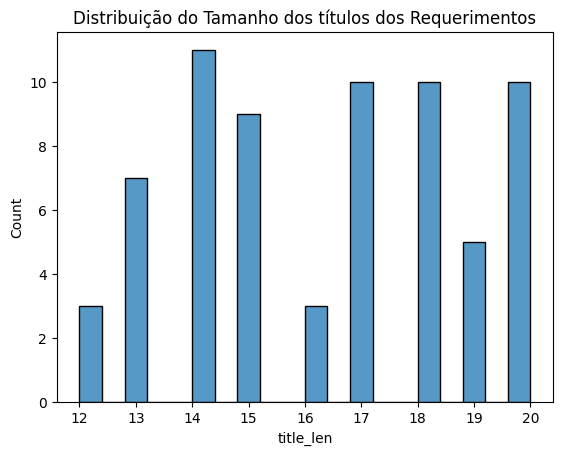

In [22]:
motions["title_len"] = motions["titulo"].str.len()
sns.histplot(motions["title_len"], bins=20)
plt.title("Distribuição do Tamanho dos títulos dos Requerimentos")

Temos que os títulos são realmente curtos e variam de  12 a 20 caracteres.

Temos nas ementas dos requerimentos um sumário do que ele se refere.

In [23]:
motions["ementa"].str.len().describe()
motions["ementa"].sample(5)

24    Requer a realização de audiência pública para ...
57    Requer a realização de audiência pública para ...
28    Requer a realização de Audiência Pública com o...
12    Requer a realização de audiência pública na Co...
66    Solicita que seja convocado o Excelentíssimo S...
Name: ementa, dtype: object

Text(0.5, 1.0, 'Distribuição do Tamanho da Ementa')

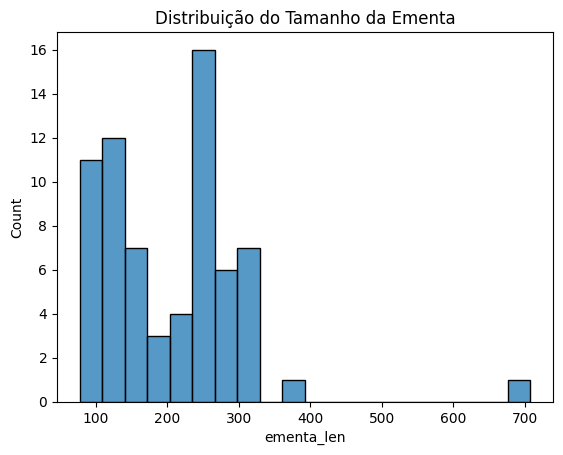

In [24]:
motions["ementa_len"] = motions["ementa"].str.len()
sns.histplot(motions["ementa_len"], bins=20)
plt.title("Distribuição do Tamanho da Ementa")

Verificamos que a maioria das ementas se encontra entre 100 e 300 caracteres, com predominância para 16 ementas com aproximados 250 caracteres.

Há uma ementa de 700 caracteres.

Text(0.5, 1.0, 'Distribuição do Tamanho do Requerimento em PDF')

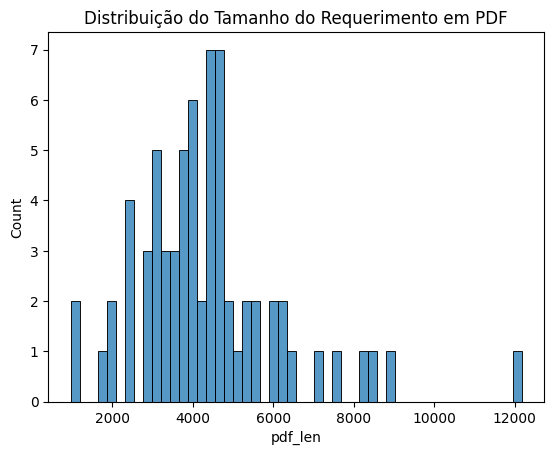

In [25]:
motions["pdf_len"] = motions["pdf_text"].str.len()
sns.histplot(motions["pdf_len"], bins=50)
plt.title("Distribuição do Tamanho do Requerimento em PDF")

In [26]:
motions["event_id"].value_counts().head()


event_id
77007    9
76919    4
76818    3
76934    3
76160    2
Name: count, dtype: int64

Temos para o evento de id 77007 a presença de 9 requerimentos! Mais que o dobro do que o segundo colocado com mais quantias.

<Axes: title={'center': 'Situação dos Requerimentos'}, ylabel='status'>

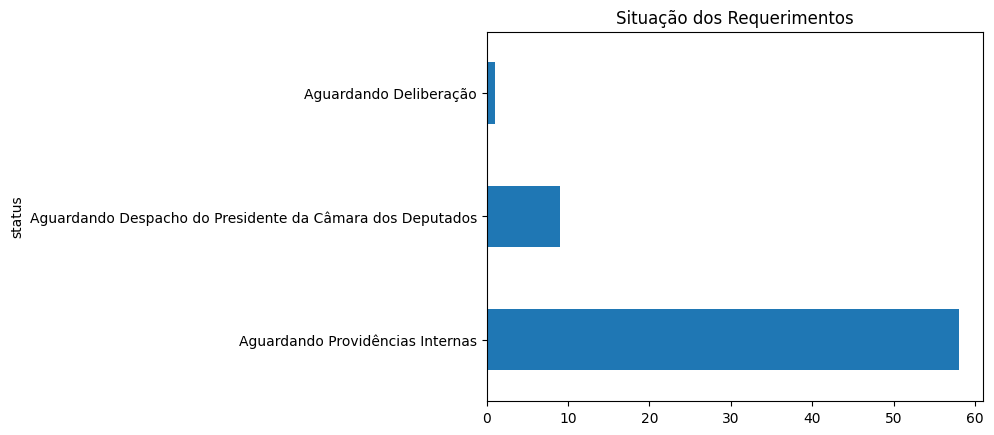

In [27]:
motions["status"].value_counts().plot(kind="barh", title="Situação dos Requerimentos")


Temos uma grande predominância do Status "Aguardando Providências Internas"

---

### Tratamento e Análise Exploratória com NLP para Eventos

Vamos partir agora para uma análise focada em NLP, para isso devemos tratar nossos dados textuais, e utilziar de técnicas como BoW, NER e Embeddings.

Para eventos vamos focar em duas colunas de interesse: descricao e topics (Pauta)



In [28]:
cleaned_events = events_with_topics.copy()

In [29]:
cleaned_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              80 non-null     int64  
 1   uri             80 non-null     object 
 2   dataHoraInicio  80 non-null     object 
 3   dataHoraFim     0 non-null      float64
 4   situacao        80 non-null     object 
 5   descricaoTipo   80 non-null     object 
 6   descricao       80 non-null     object 
 7   localExterno    15 non-null     object 
 8   orgaos          80 non-null     object 
 9   localCamara     80 non-null     object 
 10  urlRegistro     0 non-null      float64
 11  details         80 non-null     object 
 12  topics          35 non-null     object 
 13  comission       80 non-null     object 
 14  descricao_len   80 non-null     int64  
 15  topics_len      35 non-null     float64
dtypes: float64(3), int64(2), object(11)
memory usage: 10.1+ KB


In [30]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Aplicar em coluna de descrição (exemplo)
cleaned_events["descricao"] = cleaned_events["descricao"].fillna("").apply(preprocess_text)
cleaned_events["topics"] = cleaned_events["topics"].fillna("").apply(preprocess_text)


In [31]:
cleaned_events["descricao"].sample(5)

55    seminário estadual plano nacional educação San...
10    homenagem ano curso graduação enfermagem unive...
64    consolidação lei estatuto pessoa deficiência s...
58    debate situação atual perspectiva nacional aud...
31               discussão votação proposta legislativo
Name: descricao, dtype: object

In [32]:
cleaned_events["num_words"] = cleaned_events["descricao"].apply(lambda x: len(x.split()))
cleaned_events["num_chars"] = cleaned_events["descricao"].apply(len)

print("Resumo das quantidades de palavras na descrição:")
print(cleaned_events["num_words"].describe())


Resumo das quantidades de palavras na descrição:
count     80.000000
mean      48.587500
std       57.176762
min        4.000000
25%        5.750000
50%       30.000000
75%       79.000000
max      281.000000
Name: num_words, dtype: float64


Top 20 palavras mais frequentes nas decrições:
[('confirmar', 153), ('nacional', 60), ('presidente', 60), ('deputado', 53), ('req', 37), ('federal', 36), ('Brasil', 35), ('brasileiro', 35), ('representante', 34), ('educação', 33), ('legislativo', 32), ('secretário', 31), ('público', 29), ('discussão', 26), ('diretor', 25), ('nº', 24), ('associação', 23), ('convidado', 22), ('requerimento', 22), ('votação', 21)]


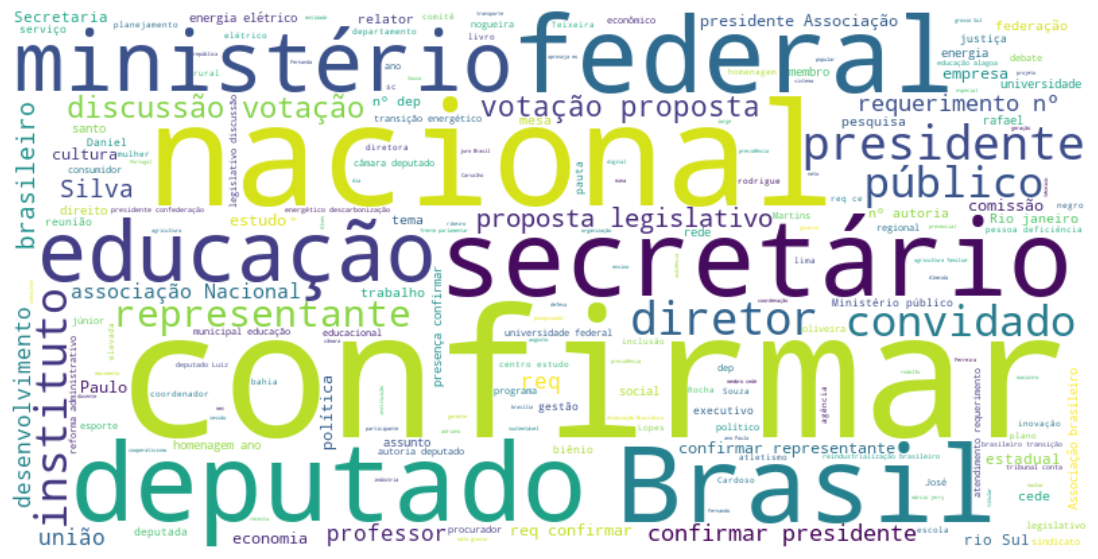

In [33]:
description = " ".join(cleaned_events["descricao"])

word_counts_descriptions = Counter(description.split())
print("Top 20 palavras mais frequentes nas decrições:")
print(word_counts_descriptions.most_common(20))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(description)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Top 20 palavras mais frequentes nas pautas:
[('nº', 278), ('lei', 234), ('deputado', 211), ('projeto', 165), ('parecer', 161), ('aprovação', 132), ('pauta', 124), ('relator', 113), ('pl', 87), ('nacional', 85), ('público', 81), ('substitutivo', 80), ('comissão', 67), ('relatora', 63), ('requerimento', 61), ('alterar', 56), ('legislativo', 53), ('apensar', 53), ('confirmar', 51), ('dia', 45)]


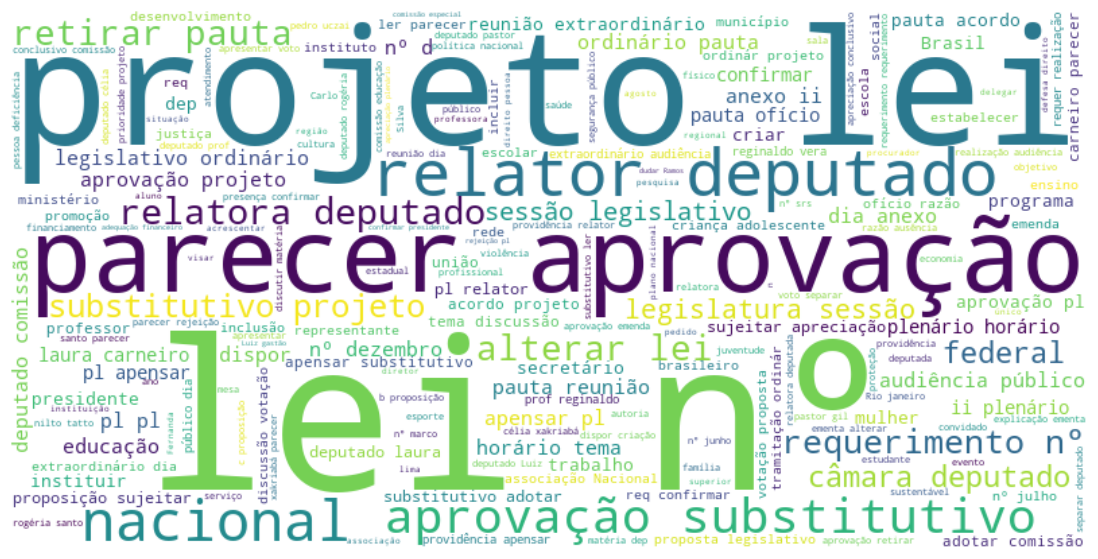

In [34]:
topics = " ".join(cleaned_events["topics"])

topics_word_counts = Counter(topics.split())
print("Top 20 palavras mais frequentes nas pautas:")
print(topics_word_counts.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topics)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Temos que em ambas Nuvens de palavras há muito a presença de jargões e palavras técnicas referentes a esses tipos de documento.

Vamos tentar identificar as entidades nomeadas

In [35]:
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

cleaned_events["entities"] = cleaned_events["descricao"].fillna("").apply(extract_ner)


In [36]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)


In [37]:
print("Tipos de entidade mais frequentes nas descrições:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")

Tipos de entidade mais frequentes nas descrições:
PER: 217 ocorrências
LOC: 122 ocorrências
ORG: 39 ocorrências
MISC: 14 ocorrências

Exemplos de entidades por tipo:
ORG: ['Associação Nacional', 'Justiça Ministério', 'Fundação vale', 'Associação', 'Nacional procurador']
PER: ['Fernanda Fernandes', 'Henrique', 'Associação', 'Pedro Caldeira', 'Geraldo']
LOC: ['EUA', 'Ferreira', 'Cardoso', 'Paulo tower', 'Mariana']
MISC: ['Miranda', 'Ministério', 'Justiça Ministério', 'Ministério cultura Liliane Garcez', 'alban presidente confederação nacional indústria cni João Martins Silva']


O tipo de entidade nomeada mais frequente é de Person (pessoas), seguido de localização.
Temos uma grande coletânea de diversos tipos de NER e da corretude delas a serem extraídas.

Fazendo o mesmo para as pautas temos:

In [38]:
cleaned_events["entities_topics"] = cleaned_events["topics"].fillna("").apply(extract_ner)

In [39]:
ent_type_counter = Counter()
ent_text_by_type = defaultdict(list)

for ents in cleaned_events["entities_topics"]:
    for text, label in ents:
        ent_type_counter[label] += 1
        ent_text_by_type[label].append(text)

print("Tipos de entidade mais frequentes nas pautas:")
for ent_type, count in ent_type_counter.most_common():
    print(f"{ent_type}: {count} ocorrências")

print("\nExemplos de entidades por tipo:")
for ent_type, texts in ent_text_by_type.items():
    exemplos = list(set(texts))[:5]  
    print(f"{ent_type}: {exemplos}")


Tipos de entidade mais frequentes nas pautas:
PER: 307 ocorrências
LOC: 102 ocorrências
ORG: 34 ocorrências
MISC: 32 ocorrências

Exemplos de entidades por tipo:
ORG: ['Associação Nacional', 'cpasf', 'Justiça Ministério', 'Nacional procurador', 'Escola nacional administração público enap']
PER: ['Fernanda Fernandes', 'Henrique', 'Fernando', 'ricardo', 'veneziano vital rêgo']
LOC: ['paraíba', 'teresina', 'Paulo tower', 'Instituto brasileiro ibr confirmar', 'rio norte']
MISC: ['Justiça Ministério', 'célia xakriabá', 'Ramos horário', 'Lei nº pl', 'Maria Ferreira Roberts']


Mantemos a predominância de pessoas seguido de localizações.

Vamos agora aplicar os dois campos de interesse para uma abordagem de embeddings, utilizando o distillBERT, com isso iremos verificar como os textos se distanciam no espaço vetorial para as diferentes comissões. Devido ao maior tamanho vamos aplicar isto apenas as Pautas.

ModuleNotFoundError: No module named 'datasets'

In [41]:
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [42]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Resgata tokenizador distilbert

In [ ]:
def tokenize(batch):
  # Garantia que os dados de texto serão strings
  texts = [str(text) for text in batch["text"]]

  # Caso acima de 512, trunca-se os dados
  # Para o caso de saúde não teremos esse comportamento
  encodings = tokenizer(texts, padding=True, truncation=True)

  # Preserva a coluna label de saída no map
  encodings["label"] = batch["label"]

  return encodings

In [83]:
topics_embedding = cleaned_events[["topics", "comission"]].dropna()
topics_embedding = topics_embedding[topics_embedding["topics"] != ""].reset_index(drop=True)

In [84]:
topics_embedding_dataset = Dataset.from_pandas(topics_embedding)

In [85]:
topics_text_encoded = topics_embedding_dataset.map(
    tokenize,
    batched=True, # Garante o processamento em batch
    batch_size=None # Define um valor dinâmico ao batch
)

Map: 100%|██████████| 35/35 [00:00<00:00, 313.73 examples/s]

['pauta cpd câmara deputado comissão defesa direito pessoa deficiência legislatura sessão legislativo ordinário pauta reunião extraordinário audiência público dia anexo ii plenário horário tema planejamento diretriz ação governo federal voltar inclusão acessibilidade promoção direito pessoa deficiência convidar anna Paula feminella presença confirmar secretário nacional direito pessoa deficiência ministério direito humano cidadania req nº autoria deputado márcio jerry req nº autoria deputado duarte jr', 'pauta cpovo câmara deputado comissão amazônia povo originário tradicional legislatura sessão legislativo ordinário pauta seminário dia anexo ii plenário horário tema inclusão diretriz educação antirracista plano nacional educação req nº autoria deputada dandarar convidado mesa saber fundante cledisson santo Ministério igualdade racial mir clélia marar santo Ministério Educação mec edson machar brito edson kayapó instituto federal bahia ifba iraneide Soares Silva Associação Brasileira p

Vamos usar agora o BERT como extrator de "features" a partir dos embeddings.

Os embeddings podem ser vistos como a representação inicial de uma palavra ou unidade de texto (seja ela estática ou contextuais).

Já os hidden states são as representações intermediárias mais complexas que o modelo constrói camada por camada, vamos extrair o hidden state dos embedding para o token [CLS] que contém informação de toda a sequência de texto.

Por estarmos lidando com poucos dados, não vai ser essencial o uso de uma GPU.

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [90]:
def extract_hidden_states(batch):

    # Repassa entradas do modelo para a GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad(): # Congela o modelo BERT, ou seja não calcula gradiente
        last_hidden_state = model(**inputs).last_hidden_state

    # Retornamos os valore da camada oculta para a CPU como um array Numpy
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

topics_text_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
) # Transforma os tokens em Tensors utilizando PyTorch

# Mapeia os Tensors com Tokens para o modelo, resgatando os valores da camada oculta
topics_hidden_features = topics_text_encoded.map(
    extract_hidden_states,
    batched=True
)


Map: 100%|██████████| 35/35 [00:20<00:00,  1.71 examples/s]


In [91]:
topics_hidden_features.column_names

['topics', 'comission', 'input_ids', 'attention_mask', 'label', 'hidden_state']

In [103]:
topics_hidden_features

Dataset({
    features: ['topics', 'comission', 'input_ids', 'attention_mask', 'label', 'hidden_state'],
    num_rows: 35
})

In [104]:
y_topics = topics_hidden_features["label"]
X_topics = topics_hidden_features.remove_columns(["topics", "comission", "label"])


In [110]:
X_topics_scaled = MinMaxScaler().fit_transform(X_topics["hidden_state"])

mapper = UMAP(n_components=2, metric="cosine").fit(X_topics_scaled)


df_embedding = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_embedding["label"] = y_topics
df_embedding.head()

c:\Users\renne\anaconda3\envs\tcc-pos\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,7.020367,-2.840282,Comissão de Defesa dos Direitos das Pessoas co...
1,8.337494,0.265502,Comissão da Amazônia e dos Povos Originários e...
2,7.181485,0.446276,Comissão de Finanças e Tributação
3,7.900227,-1.448317,Comissão de Cultura
4,8.328421,-1.357148,Comissão de Educação


In [113]:
df_embedding

,X,Y,label
0,7.020367,-2.840282,Comissão de Defesa dos Direitos das Pessoas co...
1,8.337494,0.265502,Comissão da Amazônia e dos Povos Originários e...
2,7.181485,0.446276,Comissão de Finanças e Tributação
3,7.900227,-1.448317,Comissão de Cultura
4,8.328421,-1.357148,Comissão de Educação
5,8.417916,-0.921092,Comissão de Segurança Pública e Combate ao Cri...
6,8.116405,-0.091599,Comissão de Meio Ambiente e Desenvolvimento Su...
7,7.265423,-0.220387,Comissão de Integração Nacional e Desenvolvime...
8,7.724470,0.996789,Comissão de Cultura
9,5.626445,-4.059762,Eventos


C:\Users\renne\AppData\Local\Temp\ipykernel_8220\1359967360.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


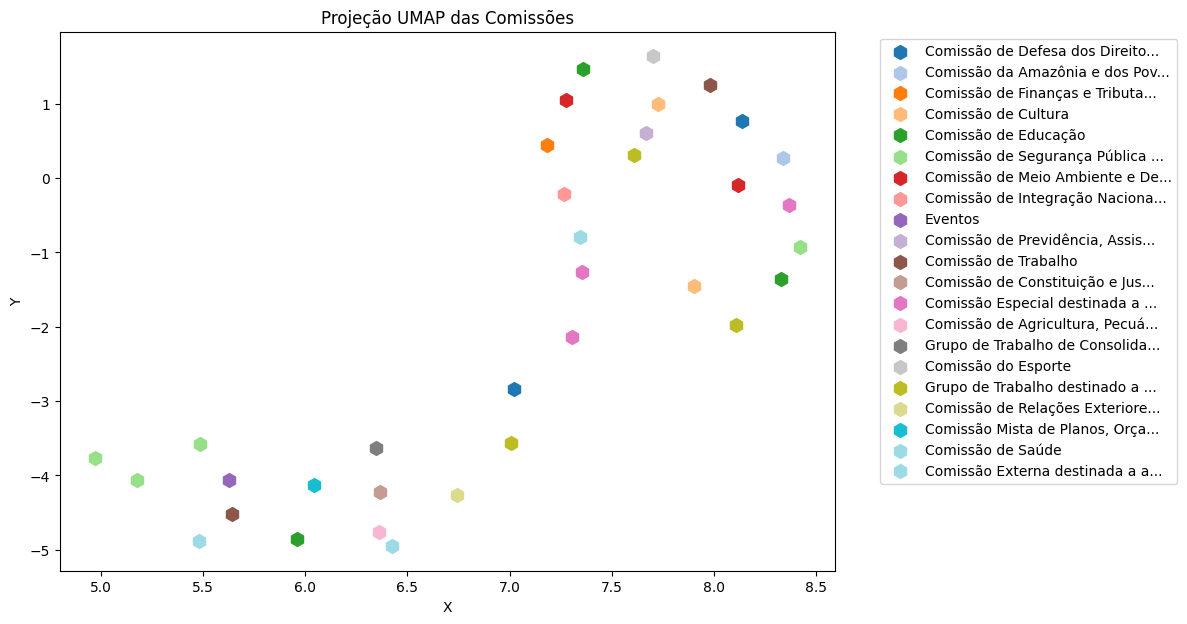

In [117]:
labels_trunc = df_embedding["label"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

plt.figure(figsize=(10,7))

unique_labels = labels_trunc.unique()
colors = plt.cm.get_cmap('tab20', len(unique_labels))

for i, label in enumerate(unique_labels):
    idx = labels_trunc == label
    plt.scatter(
        df_embedding.loc[idx, "X"], 
        df_embedding.loc[idx, "Y"], 
        label=label, 
        marker='h',  # hexágono
        s=100,       # tamanho do marcador
        color=colors(i)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Projeção UMAP das Comissões")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Devemos agora fazer os mesmos procedimentos para os Requerimentos!